In [8]:
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from boplay.acq_funs.mes_utils import sample_yn1_ymax
from boplay.kernels import se_kernel
from boplay.gp import GaussianProcess

from boplay.kde import fit_kde

In [9]:
np.random.seed(0)
import boplay

# the parent of the module
SAVE_DIR = Path(boplay.__file__).parent.parent / "paper_plots"
print(f"Pics will be saved to: {SAVE_DIR}")

Pics will be saved to: /Users/michaelp/mes/paper_plots


# Generate Data to Plot

In [10]:

x_idx = 75
idx_train = np.array([0, 50, 90])
y_noise_std = 0.5

# Generate data to plot
n_yn1 = 51
n_ymax = 50

# make a grid of x-values
x_grid = np.linspace(0, 100, 101).reshape(-1, 1)
n_x = x_grid.shape[0]

# make a train set of x-values and y-values
x_train = x_grid[idx_train, :]
y_train = np.asarray([0.5, 0.0, 1]).reshape(-1, 1)
y_best = float(max(y_train))

# make a kernel
kernel = partial(se_kernel, len_scale=10.0, sigma_f=1.0)

# make a Gaussian process
gp = GaussianProcess(x_train=x_train, y_train=y_train, kernel=kernel, y_noise_std=y_noise_std)

# get the mean and covariance of the Gaussian process
y_mean, y_cov = gp.predict(x_test=x_grid)

np.random.seed(0)
y_n1_samples, y_func_samples, y_max_samples, _ = sample_yn1_ymax(
    y_mean=y_mean,
    y_cov=y_cov,
    n_yn1=n_yn1,
    n_ymax=n_ymax,
    y_noise_std=0.5,
)

# cherry pick 3 sampled y_n1 values
y_n1_idx = np.array([n_yn1 - 1, (n_yn1 + 1) // 2, 0])


y_n1_samples = y_n1_samples[x_idx, y_n1_idx]  # (3,)
y_func_samples = y_func_samples[x_idx, y_n1_idx, :, :]  # (3, n_ymax, n_x)
y_max_samples = y_max_samples[x_idx, y_n1_idx, :]  # (3, n_ymax)
n_yn1 = 3


/var/folders/9v/87mwfydj0wq_h8g7cg3qx_600000gq/T/ipykernel_78640/3351971281.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_best = float(max(y_train))


In [11]:
y_max_samples.shape

(3, 50)

# Function to plot a GP and Samples Fucntions

In [12]:
def plot_gp_and_sample_funcs(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_mean: np.ndarray,
    y_sd: np.ndarray,
    y_sampled_funcs: np.ndarray,
    ax: plt.Axes,
    y_min: float = -4,
    y_max: float = 6,
    y_max_marker: dict = {},
) -> None:
    """
    Plot the GP and the acquisition function on the given axes.
    """
    assert x_train.shape[0] == y_train.shape[0]
    assert x_grid.shape[0] == y_mean.shape[0]
    assert y_sampled_funcs.shape[1] == y_mean.shape[0]

    x_train = x_train.reshape(-1)
    x_grid = x_grid.reshape(-1)
    y_train = y_train.reshape(-1)
    y_mean = y_mean.reshape(-1)
    y_sd = y_sd.reshape(-1)

    # Line 1/2: plot the GP and the training data
    ax.fill_between(x_grid, y_mean - 2*y_sd, y_mean + 2*y_sd, alpha=0.2)
    ax.plot(x_grid, y_mean, label='GP mean', color='k')
    ax.plot(x_train, y_train, 'o', label='Training data', zorder=10, color="k")
    ax.set_ylim(y_min, y_max)

    f_label = "f(x) samples"
    y_max_label = "y_max samples"

    for i in range(y_sampled_funcs.shape[0]):
        y_sampled_func = y_sampled_funcs[i, :]
        ax.plot(x_grid, y_sampled_func, alpha=0.1, color="red", label=f_label)
        idx_max = np.argmax(y_sampled_func)
        ax.plot(x_grid[idx_max], y_sampled_func[idx_max], label=y_max_label, zorder=9, **y_max_marker)
        f_label = None
        y_max_label = None

# Plot the GP mean + error and sampled funtcions with their peaks

1.9501189958822729
Saved figure to /Users/michaelp/mes/paper_plots/gp_samples.pdf


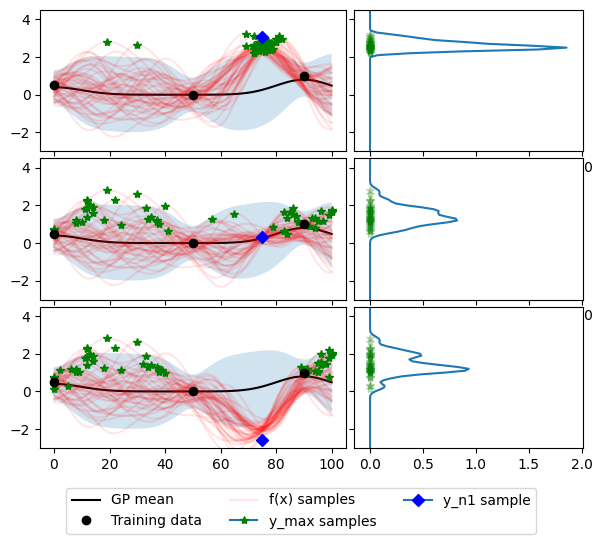

In [13]:
y_n1_marker = {
    "marker": "D",
    "markerfacecolor": "blue",
    "markeredgecolor": "blue",
    "markersize": 6,
}

y_max_marker = {
    "marker": "*",
    "markerfacecolor": "green",
    "markeredgecolor": "green",
    "markersize": 6,
}

# Desired figure width for each column
left_width_in = 4
right_width_in = 3
total_width_in = left_width_in + right_width_in
height_in = 6  # adjust as needed

fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(total_width_in, height_in),
    sharey=True,
    gridspec_kw={'width_ratios': [left_width_in, right_width_in]}
)

##### PLOT the GP and the acquisition function on each axes
kde_bws = [0.08, 0.15, 0.15]
y_sd = np.sqrt(np.diag(y_cov))
for i, axes_row in enumerate(axes):

    # Left plot: GP + sample functions
    plot_gp_and_sample_funcs(
        x_train=x_train,
        y_train=y_train,
        x_grid=x_grid,
        y_mean=y_mean,
        y_sd=y_sd,
        y_sampled_funcs=y_func_samples[i, :, :],
        ax=axes_row[0],
        y_min=-3,
        y_max=4.5,
        y_max_marker=y_max_marker,
    )
    axes_row[0].plot(x_grid[x_idx], y_n1_samples[i], label="y_n1 sample", zorder=10, **y_n1_marker)


    # Right plot: y_max sample density
    y_max_samples_i = y_max_samples[i, :]
    kde = fit_kde(y_max_samples_i, bw=kde_bws[i])
    y_grid = np.linspace(-4, 6, 101)

    axes_row[1].plot(kde.density(y_grid), y_grid)
    axes_row[1].plot(np.zeros_like(y_max_samples_i), y_max_samples_i, alpha=0.2, **y_max_marker)

# set all ymax density plots to have the same width
max_kde = max([axes[i, 1].get_xlim()[1] for i in range(3)])
for i in range(3):
    axes[i, 1].set_xlim(-0.08 * max_kde, 1.03 * max_kde)
print(max_kde)


# One legend for the whole figure, centered below all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=3,
    # bbox_to_anchor=(0.5, -0.02)
)

fig.subplots_adjust(bottom=0.15, wspace=0.03, hspace=0.05)

fig.savefig(SAVE_DIR / "gp_samples.pdf")
print("Saved figure to", SAVE_DIR / "gp_samples.pdf")